In [33]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os

import scripts
from scripts import sbi_tools
from scripts import plot_utils

%load_ext autoreload
%autoreload 2

%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

N_threads = sbi_tools.set_N_threads(6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
N_threads: 6


In [ ]:
path_script_dir = ".."

biases_vec = np.loadtxt(os.path.join(path_script_dir, "data", "biases_vec.txt"))

indicesLH = []
for ii, dir_name in enumerate(os.listdir(os.path.join(path_script_dir, "data/biased_pks"))):
    if dir_name.split('_')[0] == "biased":
        indicesLH.append(int(dir_name.split('_')[4]))
indicesLH = np.array(indicesLH)
indicesLH = np.unique(indicesLH)

(1000, 50)


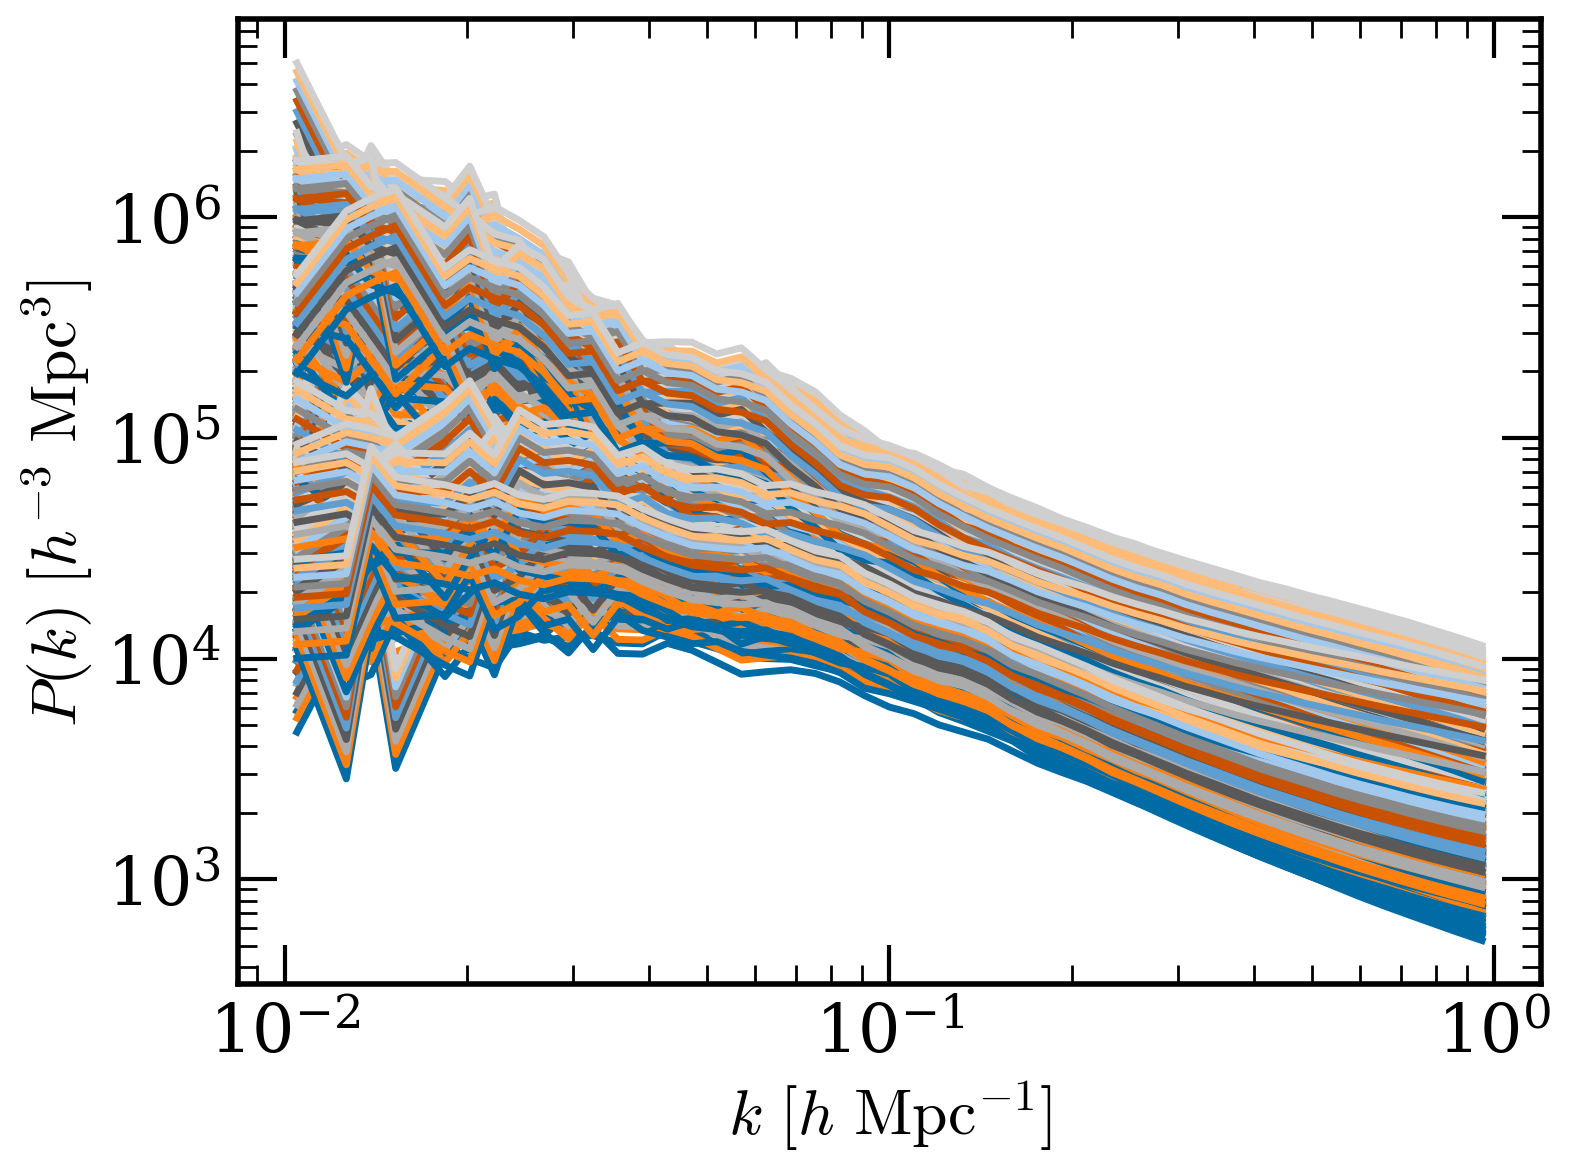

In [2]:
fig, ax = mpl.pyplot.subplots(figsize=(8, 6))
Pk = []
for iLH in range(len(indicesLH)):
    for ib in range(len(biases_vec)):
        kk, tmp_pk = np.loadtxt(os.path.join(
            path_script_dir, "data/biased_pks", 'biased_pk_m2m_num_%04d_bias_num_%d.txt'%(indicesLH[iLH], ib)
        ), unpack=True)
        Pk.append(tmp_pk)
        mask = tmp_pk > 0
        ax.loglog(kk[mask], tmp_pk[mask], label='bias %d'%ib)
Pk = np.array(Pk)
print(Pk.shape)

ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=23)

mpl.pyplot.tight_layout()
mpl.pyplot.show()

In [17]:
path_read_theta = "/dipc_storage/mpelle/Yin_data/Quijote"

theta_cosmo = []
for iLH, id_LH in enumerate(indicesLH):
    theta_cosmo.append(np.loadtxt(
        os.path.join(
            path_read_theta, "LH" + str(id_LH).zfill(4), "param_"+str(id_LH).zfill(4)+".txt")
    ))
theta_cosmo = np.array(theta_cosmo)
print(theta_cosmo.shape)


(100, 5)


In [18]:
n_biasmodels = len(biases_vec)
n_cosmos = len(theta_cosmo)
print(n_biasmodels, n_cosmos)

10 100


In [32]:
### don't include bias parameters
#theta = np.repeat(theta_cosmo, 10, axis=0)

### include b1
b1_set = biases_vec[:,0]
b1s = np.expand_dims(np.tile(b1_set, n_cosmos), axis=1)
theta = np.concatenate((np.repeat(theta_cosmo, n_biasmodels, axis=0), b1s), axis=1)

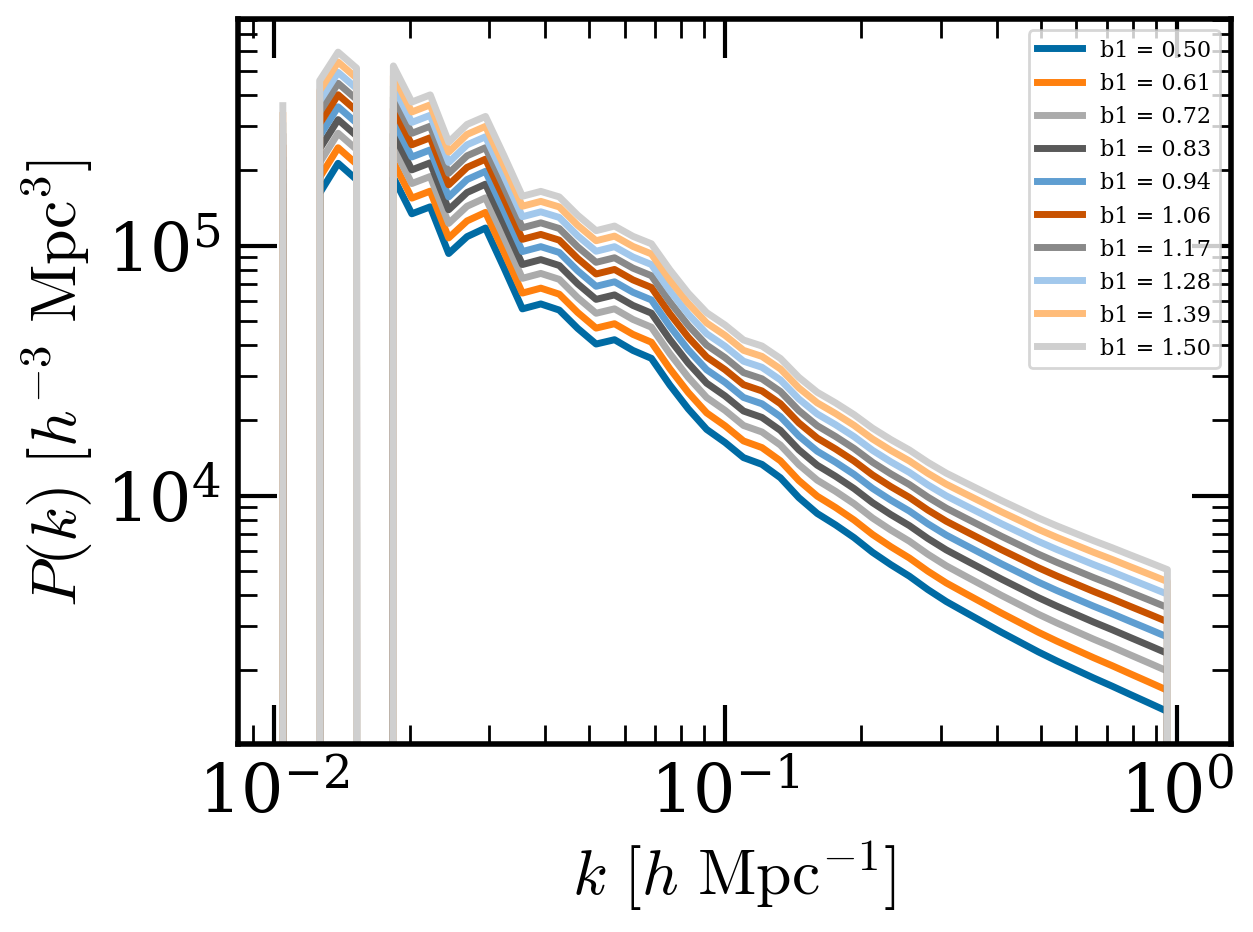

In [39]:
#iLH = 0
for i in range(n_biasmodels):
    plt.loglog(kk, Pk[i], label=f'b1 = {theta[i,-1]:.2f}')

plt.legend(fontsize=8)
ax = plt.gca()

ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=23)

mpl.pyplot.tight_layout()
mpl.pyplot.show()

In [40]:
rng = np.random.default_rng(seed=533)
n_tot = len(Pk)

i_blocks = np.arange(n_tot).reshape(n_cosmos, n_biasmodels)

i_shuffle_blocks = rng.choice(np.arange(n_cosmos), replace=False, size=n_cosmos)

i_shuffle = i_blocks[i_shuffle_blocks].flatten()

Pk = Pk[i_shuffle]
theta = theta[i_shuffle]


In [41]:
train_val_split = int(n_biasmodels*round(theta.shape[0]*0.99/n_biasmodels))

theta_train = theta[:train_val_split]
theta_test = theta[train_val_split:]
print(theta_train.shape, theta_test.shape)

Pk_train = Pk[:train_val_split]
Pk_test = Pk[train_val_split:]

mask = np.all(Pk_train>0, axis=0)
Pk_train = Pk_train[:,mask]
Pk_test = Pk_test[:,mask]
k = kk[mask]

(990, 6) (10, 6)


In [42]:
# ## ONE TRAINING SAMPLE
# Pk_train = Pk_train[:1]
# theta_train = theta_train[:1]
# print(Pk_train.shape)
# print(theta_train.shape)

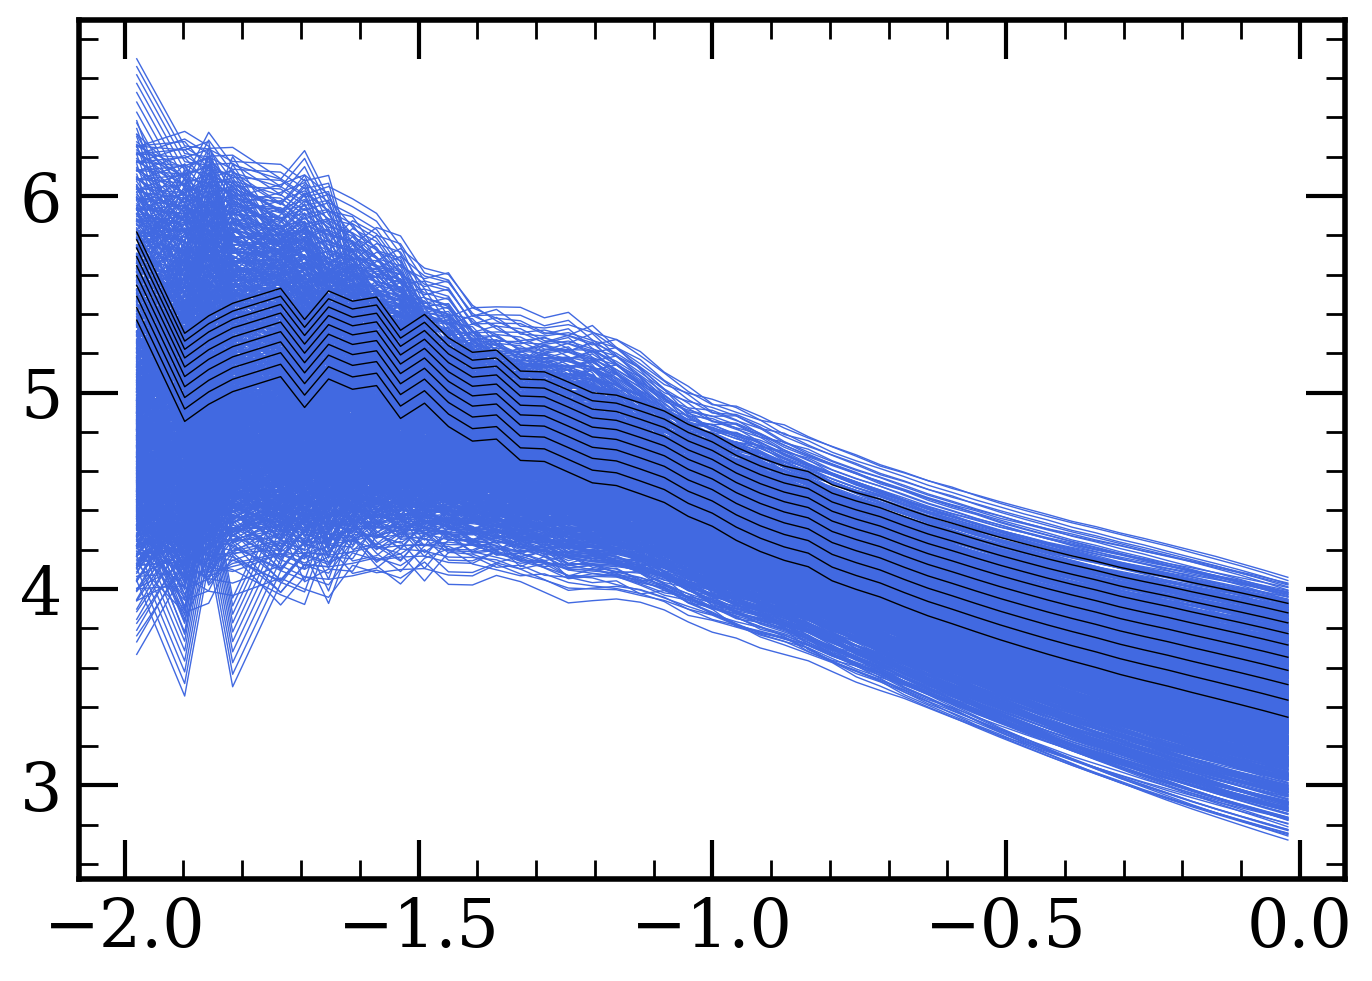

In [43]:
fig, ax = mpl.pyplot.subplots(1,1, figsize=(7,5))
fontsize = 24
fontsize1 = 18

alpha = 1

tmp_Pk_plot = Pk_train
tmp_Pk_plot = tmp_Pk_plot[np.random.choice(tmp_Pk_plot.shape[0], tmp_Pk_plot.shape[0], replace=False)].T
ax.plot(np.log10(k), np.log10(tmp_Pk_plot), c='royalblue', alpha=alpha, lw=0.5)

tmp_Pk_plot = Pk_test
tmp_Pk_plot = tmp_Pk_plot[np.random.choice(tmp_Pk_plot.shape[0], tmp_Pk_plot.shape[0], replace=False)].T
ax.plot(np.log10(k), np.log10(tmp_Pk_plot), c='k', alpha=alpha, lw=0.5)
    
mpl.pyplot.tight_layout()
mpl.pyplot.show()

In [45]:
dict_bounds = {
    'omega_m'    :  [np.min(theta, axis=0)[0], np.max(theta, axis=0)[0]],
    'omega_b'    :  [np.min(theta, axis=0)[1], np.max(theta, axis=0)[1]],
    'hubble'     :  [np.min(theta, axis=0)[2], np.max(theta, axis=0)[2]],
    'ns'         :  [np.min(theta, axis=0)[3], np.max(theta, axis=0)[3]],
    'sigma8'     :  [np.min(theta, axis=0)[4], np.max(theta, axis=0)[4]],
    'b1'         :  [np.min(theta, axis=0)[5], np.max(theta, axis=0)[5]],
}

In [46]:
class Scaler:

    def __init__(self):
          pass
        
    def fit(self, x_train):
        self.x_train_min = np.min(x_train)
        self.x_train_max = np.max(x_train)
           
    def scale(self, x):
        log_x = np.log10(x)
        log_x_norm = (log_x - np.log10(self.x_train_min)) / (np.log10(self.x_train_max) - np.log10(self.x_train_min))
        return log_x_norm
    
    def unscale(self, x_scaled):
        x = x_scaled * (np.log10(self.x_train_max) - np.log10(self.x_train_min)) + np.log10(self.x_train_min)
        return 10**x  

In [47]:
scaler = Scaler()
scaler.fit(Pk_train)
Pk_train_scaled = scaler.scale(Pk_train)
Pk_test_scaled = scaler.scale(Pk_test)

In [48]:
print(np.min(Pk_train), np.max(Pk_train))
print(np.min(Pk_train_scaled), np.max(Pk_train_scaled))

print(np.min(Pk_test), np.max(Pk_test))
print(np.min(Pk_test_scaled), np.max(Pk_test_scaled))

527.3939645606432 4998057.350607863
0.0 1.0
2223.9961191870766 655925.6902474272
0.1571665453135149 0.778219599910107


In [49]:
print(Pk_train.shape)
print(theta_train.shape)

(990, 47)
(990, 6)


In [50]:
inference, posterior = sbi_tools.train_model(
    theta_train,
    Pk_train_scaled,
    prior= sbi_tools.get_prior(dict_bounds),
    training_batch_size=16,
    validation_fraction=0.2
)

 Neural network successfully converged after 110 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 110
        Best validation performance: 14.4524
        -------------------------
        


In [64]:

#idx_train_check = rng.choice(np.arange(len(theta_train)))
idx_train_check = 42

print(idx_train_check)
theta_train_check = np.array([theta_train[idx_train_check]])
print(theta_train_check)
Pk_train_scaled_check = np.array([Pk_train_scaled[idx_train_check]])

42
[[0.3289     0.06375    0.5207     1.0467     0.8261     0.72222222]]


In [65]:
# ------------------ posterior inference ------------------ #

# norm_xx_test = scaler.transform(xx_test)

inferred_theta_train_check = sbi_tools.sample_posteriors_theta_test(
    posterior,
    Pk_train_scaled_check,
    dict_bounds,
    N_samples=1000
)

# ------------------ rank stats ------------------ #

ranks_train_check = sbi_tools.compute_ranks(theta_train_check, inferred_theta_train_check)

0


Drawing 1000 posterior samples: 1073it [00:04, 256.12it/s]                         


In [69]:
custom_titles = [
    r'$\Omega_\mathrm{m}$',
    r'$\Omega_\mathrm{b}$',
    r'$h$',
    r'$n_\mathrm{s}$',
    r'$\sigma_{8}$',
    r'$b_1$'
]

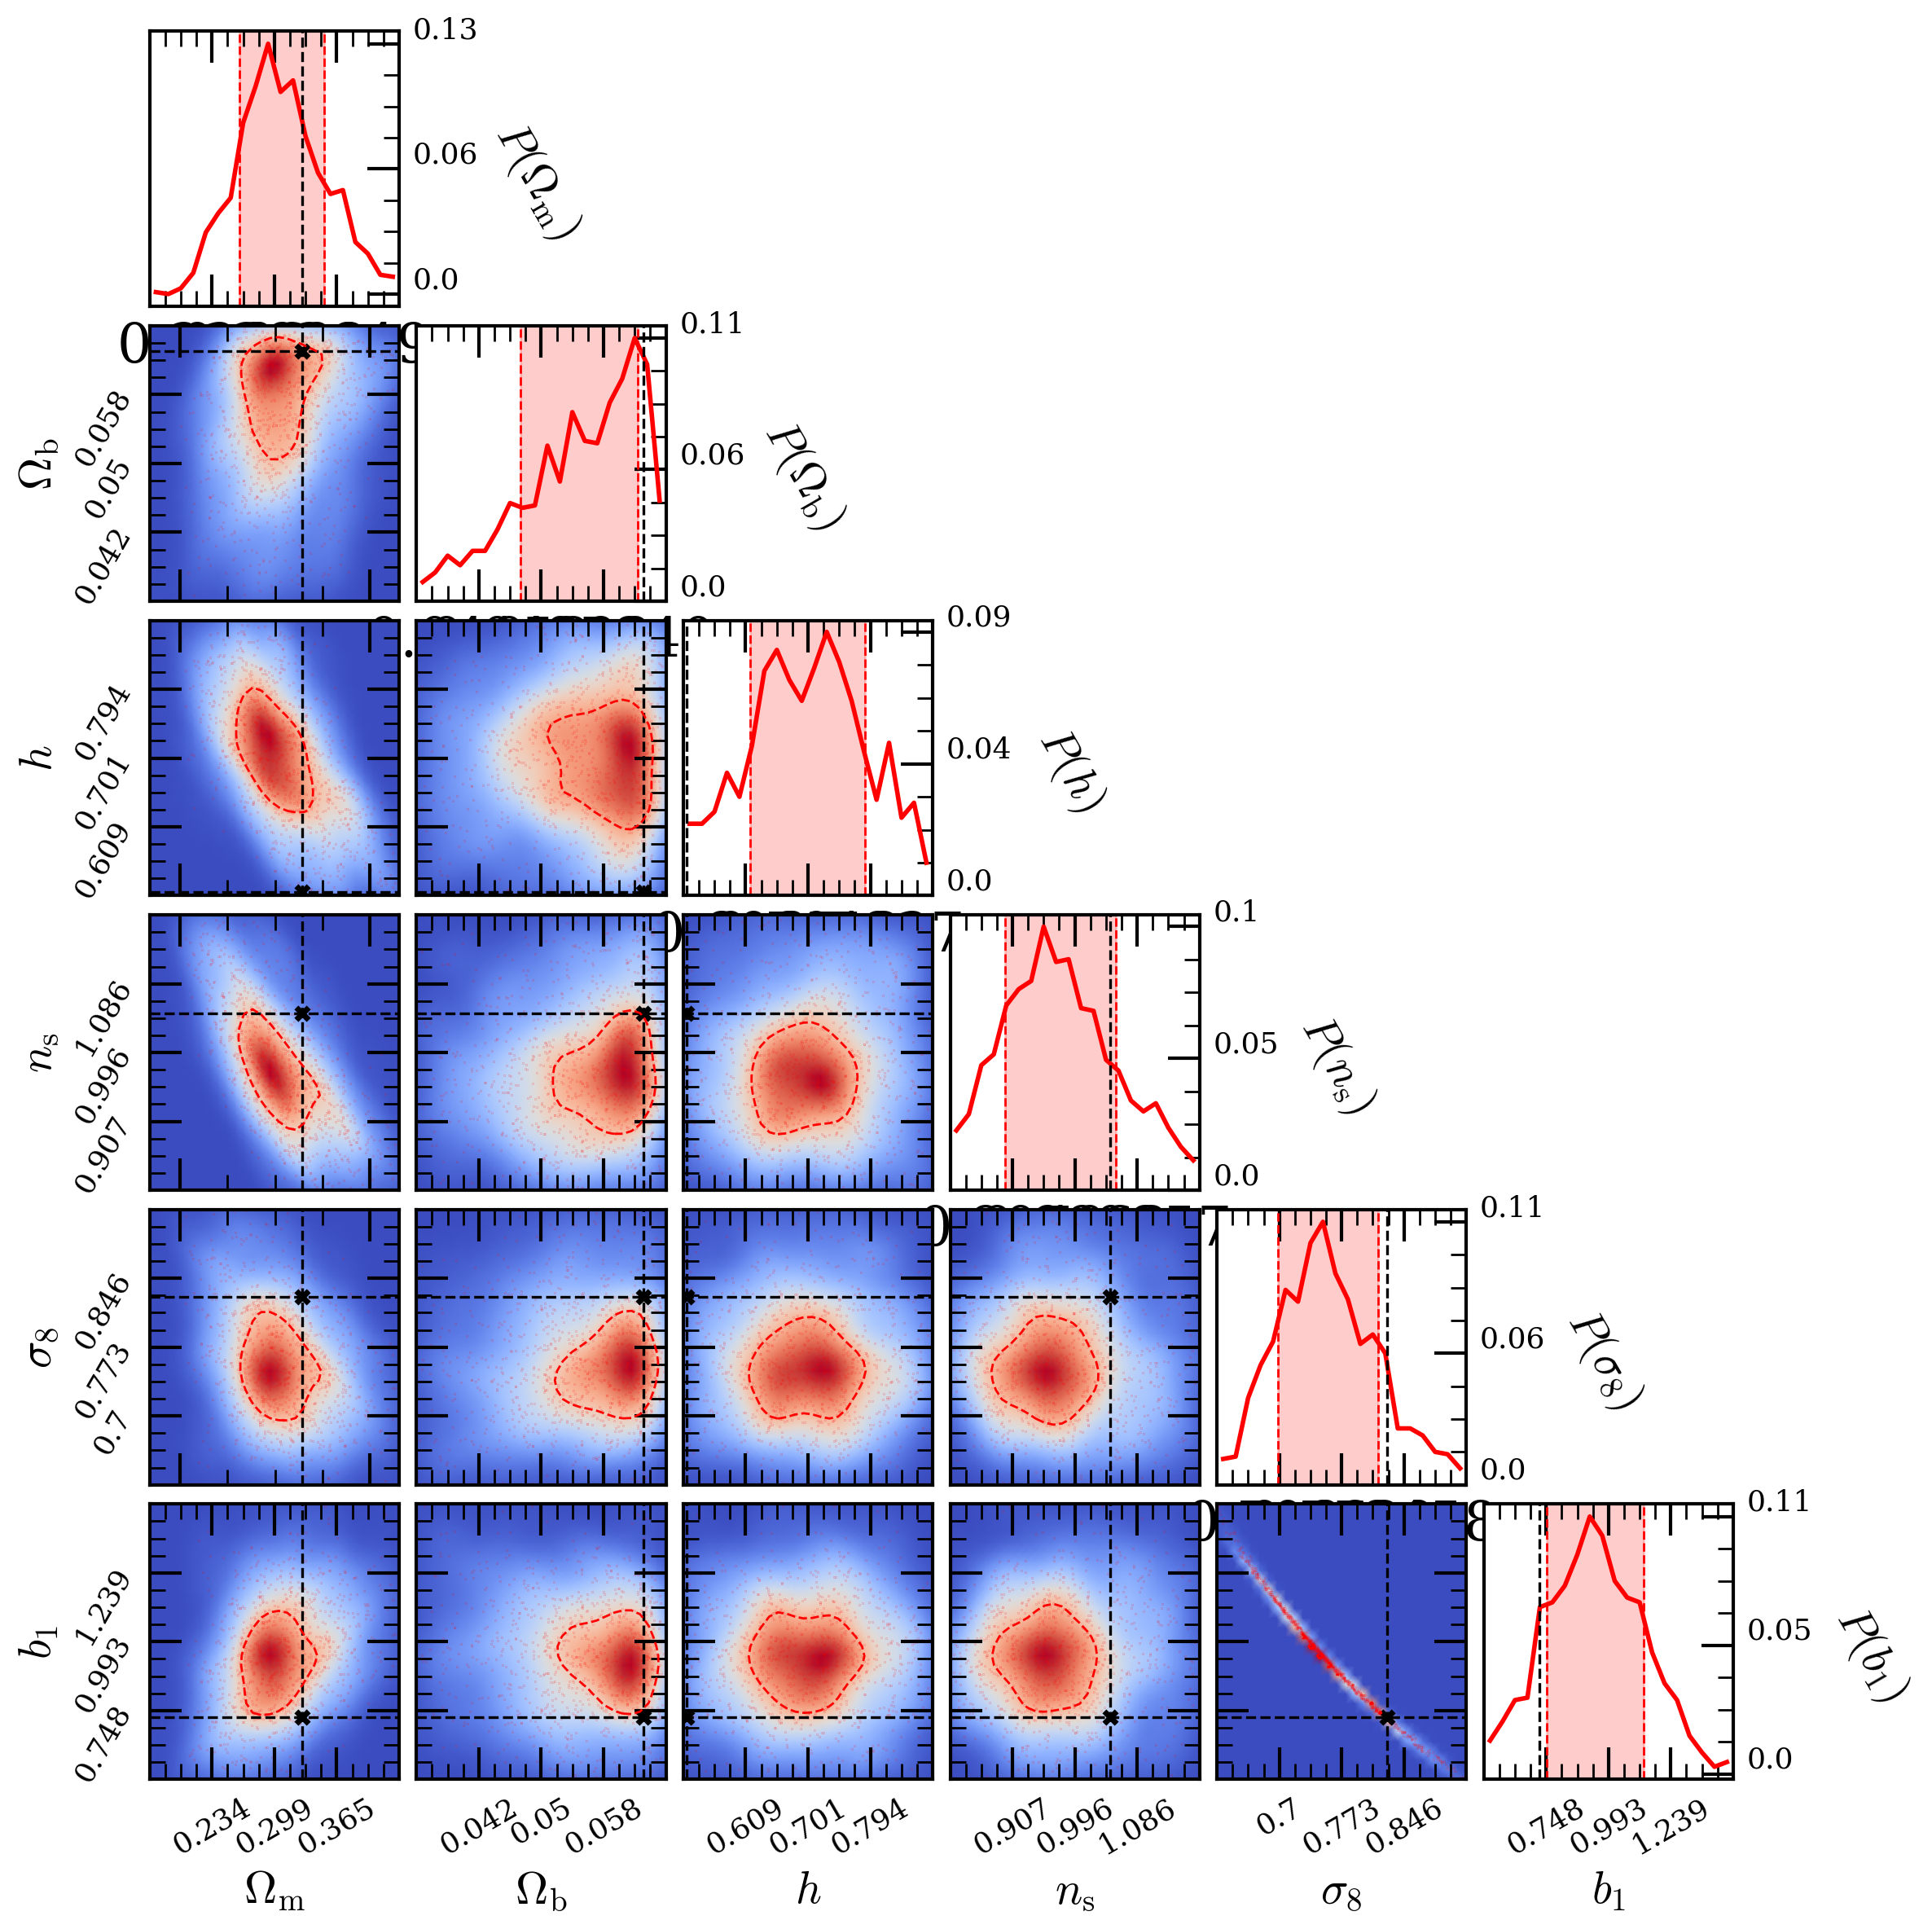

In [66]:
N_examples = 1

colors = plot_utils.get_N_colors(N_examples, mpl.colormaps['prism'])
for ii_sample in range(N_examples):
    fig, axs = plot_utils.corner_plot(
        theta_train_check[ii_sample],
        inferred_theta_train_check[ii_sample],
        custom_titles,
        dict_bounds,
        color_infer=colors[ii_sample]
    )
    mpl.pyplot.show()
    
#fig.save("popopo.png")

In [ ]:
# posterior_sample = posterior.sample((1,))
# print(posterior_sample)

In [67]:
# ------------------ posterior inference ------------------ #

# norm_xx_test = scaler.transform(xx_test)

inferred_theta_test = sbi_tools.sample_posteriors_theta_test(
    posterior,
    Pk_test_scaled,
    dict_bounds,
    N_samples=1000
)

# ------------------ rank stats ------------------ #

ranks = sbi_tools.compute_ranks(theta_test, inferred_theta_test)

0


Drawing 1000 posterior samples: 1095it [00:08, 124.22it/s]                         
Drawing 1000 posterior samples: 1075it [00:02, 390.31it/s]                         
Drawing 1000 posterior samples: 1088it [00:06, 168.62it/s]                         
Drawing 1000 posterior samples: 1125it [00:02, 449.75it/s]                         
Drawing 1000 posterior samples: 1177it [00:08, 139.78it/s]                        
Drawing 1000 posterior samples: 1171it [00:13, 89.54it/s]                         
Drawing 1000 posterior samples: 1271it [00:02, 469.78it/s]                         
Drawing 1000 posterior samples: 1279it [00:02, 553.14it/s]                         
Drawing 1000 posterior samples: 1480it [00:05, 276.05it/s]                        
Drawing 1000 posterior samples: 1439it [00:11, 122.39it/s]                        


In [ ]:
# tmp_inferred_xx_test = sbi_data_utils.compute_baccoemu_predictions_batch(
#     inferred_theta_train_check[indexes],
#     list(dict_bounds.keys())
# )

# fig, ax, ax_res = plot_utils.plot_xx_from_sampled_posteriors(xx_test[indexes], tmp_inferred_xx_test, kk)
# plt.show()

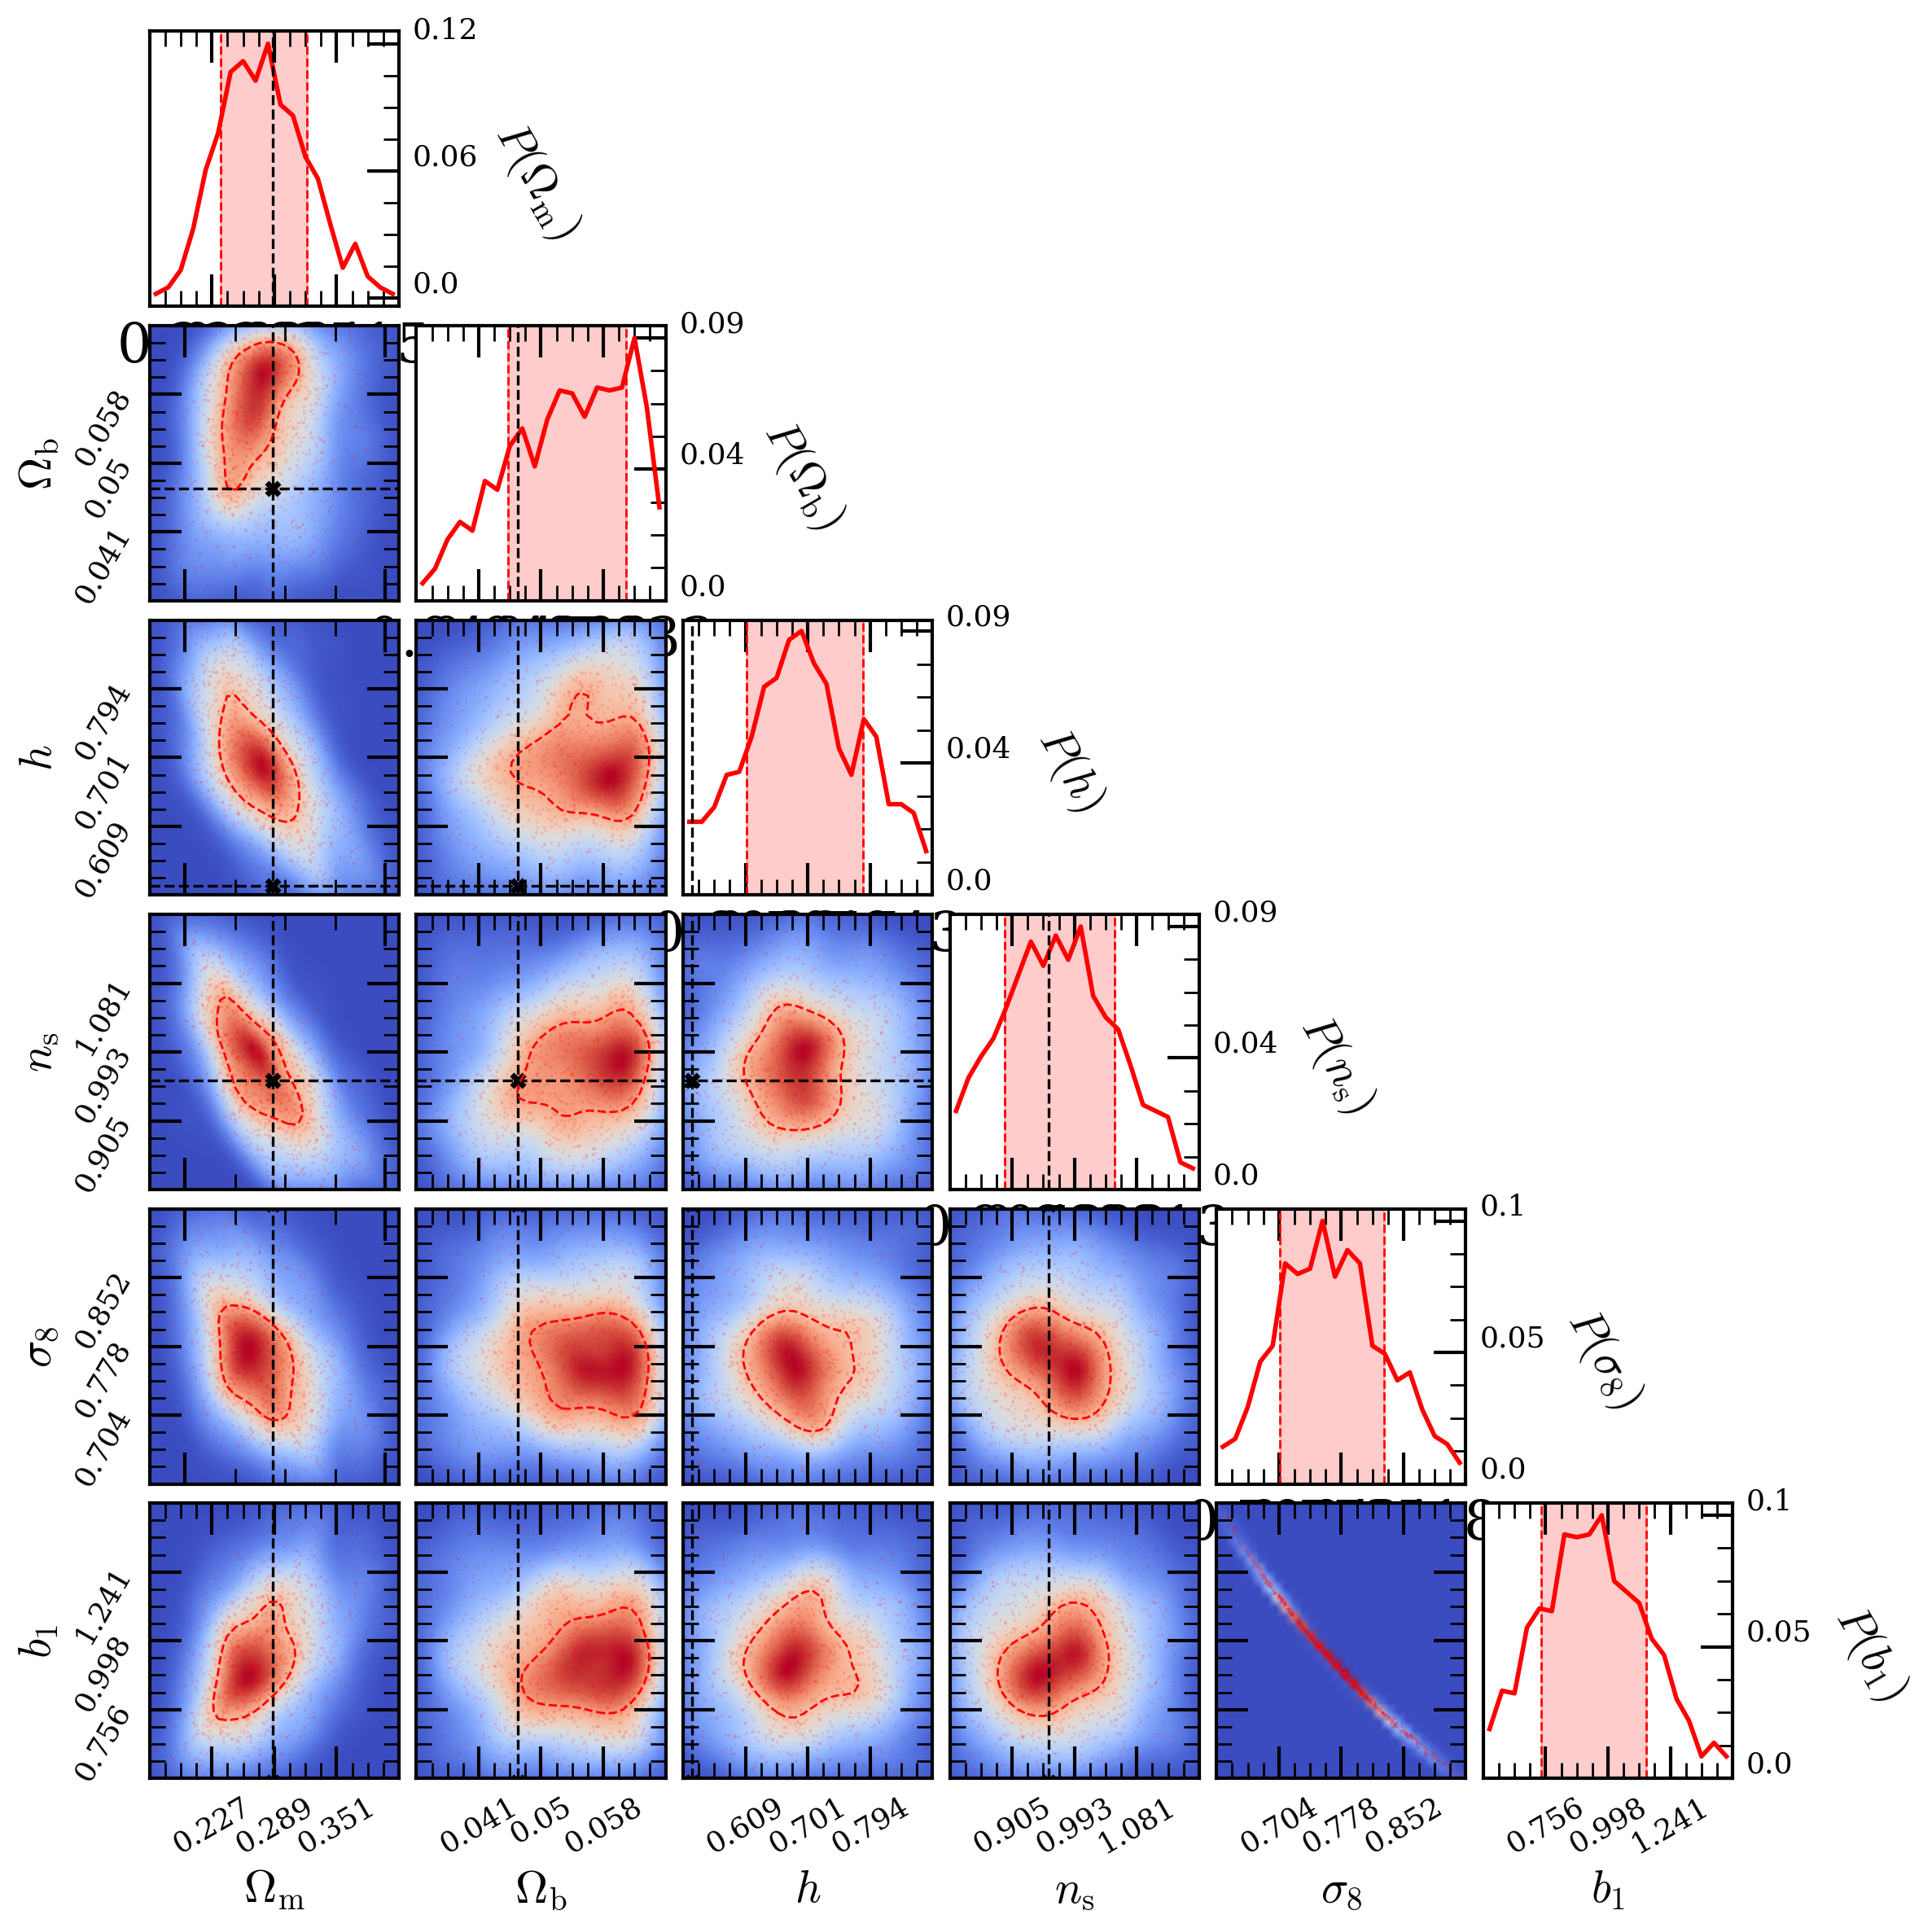

In [70]:
N_examples = 1

colors = plot_utils.get_N_colors(N_examples, mpl.colormaps['prism'])
for ii_sample in range(N_examples):
    fig, axs = plot_utils.corner_plot(
        theta_test[ii_sample],
        inferred_theta_test[ii_sample],
        custom_titles,
        dict_bounds,
        color_infer=colors[ii_sample]
    )
    mpl.pyplot.show()
    
#fig.save("popopo.png")

In [ ]:
fig, axs = plot_utils.plot_parameter_prediction_vs_truth(inferred_theta_test, theta_test, custom_titles)
plt.tight_layout()
plt.subplots_adjust(wspace=0.6)
plt.show()

In [ ]:
inference, posterior = sbi_tools.train_model(
    theta_train,
    Pk_train_scaled,
    prior= sbi_tools.get_prior(dict_bounds)
)

 Neural network successfully converged after 229 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 229
        Best validation performance: 17.5426
        -------------------------
        


In [ ]:
# ------------------ posterior inference ------------------ #

# norm_xx_test = scaler.transform(xx_test)

inferred_theta_test = sbi_tools.sample_posteriors_theta_test(
    posterior,
    Pk_test_scaled,
    dict_bounds,
    N_samples=100
)

# ------------------ rank stats ------------------ #

ranks = sbi_tools.compute_ranks(theta_test, inferred_theta_test,)

0


Drawing 100 posterior samples: 148it [00:03, 46.21it/s]                        
Drawing 100 posterior samples: 152it [00:00, 726.98it/s]                        
Drawing 100 posterior samples: 150it [00:00, 533.72it/s]                        
Drawing 100 posterior samples: 157it [00:00, 544.26it/s]                        
Drawing 100 posterior samples: 169it [00:00, 728.11it/s]                        
Drawing 100 posterior samples: 170it [00:00, 750.18it/s]                        
Drawing 100 posterior samples: 163it [00:02, 63.19it/s]                        
Drawing 100 posterior samples: 172it [00:00, 588.22it/s]                        
Drawing 100 posterior samples: 166it [00:00, 710.05it/s]                        
Drawing 100 posterior samples: 172it [00:00, 907.59it/s]                        


In [ ]:
fig, axs = plot_utils.plot_rank_statistcis(ranks, inferred_theta_test.shape[1], custom_titles)
plt.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.show()